# Sentiment analysis for drug review

In [8]:
#import libraries
import pandas as pd
import os
import sys
import keras
import tensorflow as tf
#CountVectorizer converts written text to token counts
from sklearn.feature_extraction.text import CountVectorizer 
import numpy as np
import warnings
#import visualisation libaries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# regular expressions for removing special characters, such as punctuation
import re
# gensim is a library for text processing including n-gram models
import gensim
from gensim.utils import simple_preprocess
# spacy is also for text processing, here we are using the lemmatiser
import spacy
from wordcloud import WordCloud


In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Embedding, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight

In [6]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset
drug_reviews_drugs_com = fetch_ucirepo(id=462)

# get the data as a single DataFrame
data = drug_reviews_drugs_com.data



In [9]:
# Create DataFrame for 'ids'
ids_df = pd.DataFrame(data['ids'])

# Create DataFrame for 'features'
features_df = pd.DataFrame(data['features'])

# Concatenate 'ids' and 'features' DataFrames
drug_reviews_df = pd.concat([ids_df, features_df], axis=1)

# Display the DataFrame
print(drug_reviews_df.head())

       id                  drugName                     condition  \
0  206461                 Valsartan  Left Ventricular Dysfunction   
1   95260                Guanfacine                          ADHD   
2   92703                    Lybrel                 Birth Control   
3  138000                Ortho Evra                 Birth Control   
4   35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37  


In [10]:
# Selecting only the desired columns
df = drug_reviews_df[['review', 'rating']]

# Display the DataFrame
print(df.head())


                                              review  rating
0  "It has no side effect, I take it in combinati...       9
1  "My son is halfway through his fourth week of ...       8
2  "I used to take another oral contraceptive, wh...       5
3  "This is my first time using any form of birth...       8
4  "Suboxone has completely turned my life around...       9


In [11]:
# Define threshold values
positive_threshold = 7
negative_threshold = 3

# Categorize ratings
def categorize_sentiment(x):
    if x >= positive_threshold:
        return 'positive'
    elif x <= negative_threshold:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(categorize_sentiment)

# Display the updated DataFrame
print(df.head())




                                              review  rating sentiment
0  "It has no side effect, I take it in combinati...       9  positive
1  "My son is halfway through his fourth week of ...       8  positive
2  "I used to take another oral contraceptive, wh...       5   neutral
3  "This is my first time using any form of birth...       8  positive
4  "Suboxone has completely turned my life around...       9  positive


C:\Users\User\AppData\Local\Temp\ipykernel_23700\1367745889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['rating'].apply(categorize_sentiment)


In [12]:
df


,review,rating,sentiment
0,"""It has no side effect, I take it in combinati...",9,positive
1,"""My son is halfway through his fourth week of ...",8,positive
2,"""I used to take another oral contraceptive, wh...",5,neutral
3,"""This is my first time using any form of birth...",8,positive
4,"""Suboxone has completely turned my life around...",9,positive
...,...,...,...
215058,"""I have taken Tamoxifen for 5 years. Side effe...",10,positive
215059,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,positive
215060,"""I&#039;m married, 34 years old and I have no ...",8,positive
215061,"""I was prescribed Nucynta for severe neck/shou...",1,negative


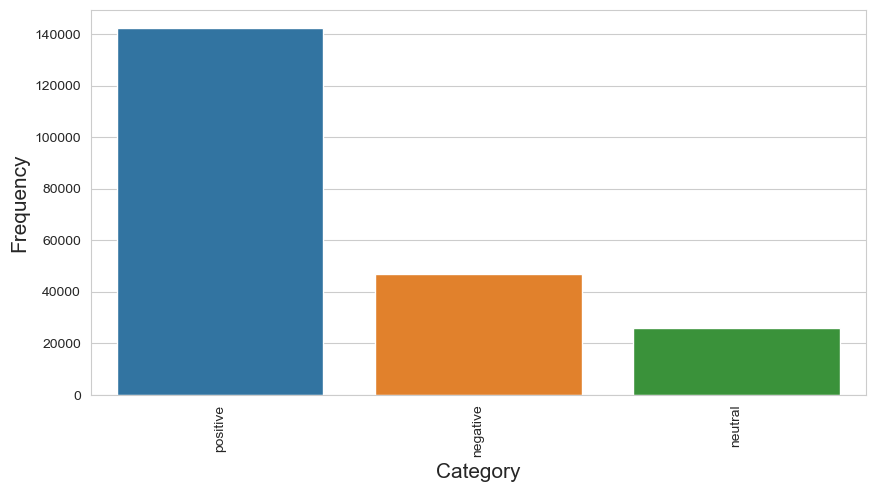

In [13]:
# Calculate frequency counts of categories
sentiment = df['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,5))
sns.barplot(x=sentiment.index, y=sentiment.values)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Category', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [14]:
# Assuming you have a DataFrame 'df' with a column 'sentiment'
sentiment_counts = Counter(df['sentiment'])

# Print the counts
print("Positive sentiment count:", sentiment_counts.get('positive', 0))
print("Negative sentiment count:", sentiment_counts.get('negative', 0))
print("Neutral sentiment count:", sentiment_counts.get('neutral', 0))

Positive sentiment count: 142306
Negative sentiment count: 46901
Neutral sentiment count: 25856


# Data Cleaning 

**Remove punctuation**

In [16]:
# Remove punctuation
df['review'] = df['review'].astype(str).apply(lambda x : re.sub('[^a-zA-Z0-9\s]', '', x))


C:\Users\User\AppData\Local\Temp\ipykernel_23700\2890765582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].astype(str).apply(lambda x : re.sub('[^a-zA-Z0-9\s]', '', x))


**convert to lowercase**

In [17]:
# Convert the titles to lowercase
df['review'] = df['review'].apply(str).map(lambda x: x.lower())


# Print out the first rows of reviews
print(df['review'].apply(str).head())


0    it has no side effect i take it in combination...
1    my son is halfway through his fourth week of i...
2    i used to take another oral contraceptive whic...
3    this is my first time using any form of birth ...
4    suboxone has completely turned my life around ...
Name: review, dtype: object


C:\Users\User\AppData\Local\Temp\ipykernel_23700\1829514847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].apply(str).map(lambda x: x.lower())


**Tokenization**

In [18]:
#Create a function that seperates the sentences into single words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False)) # 

#create a list of the sentences in the question column
revw_data = df['review'].tolist()

#Use the function to seperate the words
revw_data_words = list(sent_to_words(revw_data))

#Print the first list
print('data_words[:1]', revw_data_words[:1])


data_words[:1] [['it', 'has', 'no', 'side', 'effect', 'take', 'it', 'in', 'combination', 'of', 'bystolic', 'mg', 'and', 'fish', 'oil']]


**Lemmatisation**

In [19]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Perform lemmatization on a list of texts using spaCy.

    Args:
    texts (list): List of texts to be lemmatized.
    allowed_postags (list): List of allowed part-of-speech tags for lemmatization. Default is ['NOUN', 'ADJ', 'VERB', 'ADV'].

    Returns:
    list: List of lemmatized texts.
    """
    texts_out = []  # Initialize an empty list to store the lemmatized texts
    for sent in texts:  # Iterate over each text in the input list
        doc = nlp(" ".join(sent))  # Join the list of tokens into a single string and process it with spaCy
        # Extract the lemmatized form of each token if its part-of-speech tag is in the allowed list
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out  # Return the list of lemmatized texts


In [20]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv for quest_data
revw_data_lemmatized = lemmatization(revw_data_words)

print('revw_data_lemmatized[:1]', revw_data_lemmatized[:1])


revw_data_lemmatized[:1] [['side', 'effect', 'take', 'combination', 'bystolic', 'mg', 'fish', 'oil']]


**Remove stopwords**

In [21]:
from gensim.parsing.preprocessing import STOPWORDS

In [22]:
my_stop_words = STOPWORDS.union(set([ "the", "and", "is", "in", "it", "of", "for", "to", "a",])) #specify stop words to remove

In [23]:
def remove_stopwords(texts):
    """
    Remove stopwords from a list of texts.

    Args:
    texts (list): List of texts from which stopwords are to be removed.

    Returns:
    list: List of texts with stopwords removed.
    """
    return [[word for word in simple_preprocess(str(doc)) if word not in my_stop_words] for doc in texts]


In [24]:
revw_data_no_stops = remove_stopwords(revw_data_lemmatized)

**Generate the bigrams and trigrams**

In [25]:
#find two words commonly found together(bigrams) in the list of words
bigram = gensim.models.phrases.Phrases(revw_data_no_stops, min_count=10, threshold=100)

#find three words commonly found together(bigrams) in the list of words
trigram = gensim.models.phrases.Phrases(bigram[revw_data_no_stops], threshold=200)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


#Print out the bigrams
for bigram in bigram_mod.phrasegrams.keys():
    print(bigram)

fish_oil
oral_contraceptive
brown_discharge
pin_needle
heart_palpitation
yeast_infection
runny_nose
bounce_wall
schizoaffective_disorder
mental_illness
self_esteem
magnesium_citrate
finger_cross
viral_load
fallopian_tube
uterine_lining
primary_care
trigeminal_neuralgia
anti_depressant
benign_prostate
prostate_hyperplasia
erectile_dysfunction
copper_iud
urgent_care
jaw_clenching
restless_leg
fall_asleep
pleasantly_surprised
eating_habit
pay_attention
auditory_hallucination
contact_dermatitis
waste_money
blur_vision
urgency_frequency
chap_lip
green_tea
ms_contin
spiral_downward
car_accident
double_mastectomy
heating_pad
ankylose_spondylitis
beta_blocker
atrial_fibrillation
metoprolol_tartrate
bowel_movement
social_setting
hot_flash
red_blotch
rescue_inhaler
sky_rocket
college_student
milk_supply
tylenol_codeine
self_harm
mental_health
spinal_fusion
starter_pack
abscessed_tooth
spinal_cord
cord_injury
crave_sweet
drs_office
genetic_testing
diaper_rash
cup_size
compression_fracture
lactose

In [26]:
# Print out trigrams
for trigram in trigram_mod.phrasegrams.keys():
    print(trigram)

fish_oil
oral_contraceptive
brown_discharge
pale_comparison
pin_needle
heart_palpitation
yeast_infection
runny_nose
bounce_wall
schizoaffective_disorder
mental_illness
self_esteem
magnesium_citrate
finger_cross
viral_load
fallopian_tube
uterine_lining
trigeminal_neuralgia
anti_depressant
benign_prostate
benign_prostate_hyperplasia
erectile_dysfunction
copper_iud
cheese_grater
urgent_care
jaw_clenching
restless_leg
fall_asleep
pleasantly_surprised
eating_habit
pay_attention
auditory_hallucination
contact_dermatitis
waste_money
nicoderm_cq
blur_vision
chap_lip
green_tea
ms_contin
spiral_downward
car_accident
double_mastectomy
bread_rice
heating_pad
ankylose_spondylitis
beta_blocker
atrial_fibrillation
metoprolol_succinate
metoprolol_tartrate
bowel_movement
social_setting
hot_flash
red_blotch
rescue_inhaler
sky_rocket
college_student
self_harm
mental_health
spinal_fusion
starter_pack
abscessed_tooth
gifted_program
spinal_cord
crave_sweet
genetic_testing
diaper_rash
traumatic_event
cup_siz

In [27]:
# Initialize lists to store bigrams and trigrams
bigrams_list = []
trigrams_list = []

# Iterate through the bigrams and trigrams and append them to the lists
for bigram in bigram_mod.phrasegrams.keys():
    bigrams_list.append("_".join(bigram))

for trigram in trigram_mod.phrasegrams.keys():
    trigrams_list.append("_".join(trigram))

# Print the generated bigrams and trigrams
print("Bigrams:", bigrams_list)
print("Trigrams:", trigrams_list)


Bigrams: ['f_i_s_h___o_i_l', 'o_r_a_l___c_o_n_t_r_a_c_e_p_t_i_v_e', 'b_r_o_w_n___d_i_s_c_h_a_r_g_e', 'p_i_n___n_e_e_d_l_e', 'h_e_a_r_t___p_a_l_p_i_t_a_t_i_o_n', 'y_e_a_s_t___i_n_f_e_c_t_i_o_n', 'r_u_n_n_y___n_o_s_e', 'b_o_u_n_c_e___w_a_l_l', 's_c_h_i_z_o_a_f_f_e_c_t_i_v_e___d_i_s_o_r_d_e_r', 'm_e_n_t_a_l___i_l_l_n_e_s_s', 's_e_l_f___e_s_t_e_e_m', 'm_a_g_n_e_s_i_u_m___c_i_t_r_a_t_e', 'f_i_n_g_e_r___c_r_o_s_s', 'v_i_r_a_l___l_o_a_d', 'f_a_l_l_o_p_i_a_n___t_u_b_e', 'u_t_e_r_i_n_e___l_i_n_i_n_g', 'p_r_i_m_a_r_y___c_a_r_e', 't_r_i_g_e_m_i_n_a_l___n_e_u_r_a_l_g_i_a', 'a_n_t_i___d_e_p_r_e_s_s_a_n_t', 'b_e_n_i_g_n___p_r_o_s_t_a_t_e', 'p_r_o_s_t_a_t_e___h_y_p_e_r_p_l_a_s_i_a', 'e_r_e_c_t_i_l_e___d_y_s_f_u_n_c_t_i_o_n', 'c_o_p_p_e_r___i_u_d', 'u_r_g_e_n_t___c_a_r_e', 'j_a_w___c_l_e_n_c_h_i_n_g', 'r_e_s_t_l_e_s_s___l_e_g', 'f_a_l_l___a_s_l_e_e_p', 'p_l_e_a_s_a_n_t_l_y___s_u_r_p_r_i_s_e_d', 'e_a_t_i_n_g___h_a_b_i_t', 'p_a_y___a_t_t_e_n_t_i_o_n', 'a_u_d_i_t_o_r_y___h_a_l_l_u_c_i_n_a_t_i_o_n', 'c_o_

# Generating a WordCloud


In [28]:
def getWordCloud(hashtags):
    """
    Generate a word cloud from a list of hashtags.

    Args:
    hashtags (list): List of hashtags.

    Returns:
    None
    """
    # Read the whole text by joining the list of hashtags into a single string
    text = ' '.join(hashtags)
    
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)
    
    # Display the generated image using matplotlib
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")  # Turn off axis labels
    
    # Lower max_font_size for better visualization
    wordcloud = WordCloud(max_font_size=40).generate(text)
    
    # Create a new figure for the word cloud
    plt.figure()
    
    # Display the new word cloud image
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.


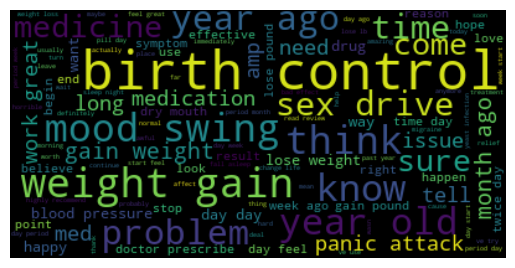

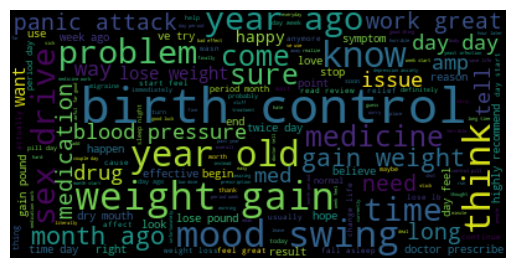

In [29]:
# Create an empty list to store the joined strings
revw_strings = []

# Iterate over each list in revw_data_no_stops
for l in revw_data_no_stops:
    # Join the words in the current list into a single string
    t = ' '.join(l)
    
    # Append the joined string to the revw_strings list
    revw_strings.append(t)

# Call the getWordCloud function with the list of joined strings as input
getWordCloud(revw_strings)


In [30]:
# assign x to the processed text
x=revw_strings
#assign y to the sentiments
y=df['sentiment']


In [31]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation and test data using the fitted vectorizer
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply oversampling to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Now X_train_resampled and y_train_resampled are balanced

# Print categories and their counts
category_counts = Counter(y_train_resampled)
print("Categories and their counts in y_train_resampled:")
for category, count in category_counts.items():
    print(f"{category}: {count}")




Categories and their counts in y_train_resampled:
negative: 91126
neutral: 91126
positive: 91126


**A baseline classifier**

In [32]:
from sklearn.dummy import DummyClassifier


# Create a majority class classifier
majority_classifier = DummyClassifier(strategy="most_frequent")

# Train the classifier 
majority_classifier.fit(X_train, y_train)

# Predict the majority class(positive)
y_pred_majority = majority_classifier.predict(X_test)

# Calculate accuracy of the majority class classifier
baseline_accuracy = accuracy_score(y_test, y_pred_majority)

print("Majority Class Baseline Accuracy:", baseline_accuracy)


Majority Class Baseline Accuracy: 0.6590100667240136


# Naive Bayes

In [33]:
# Initialize the Naive Bayes classifier
clf = MultinomialNB()

In [34]:
# Create a Naive Bayes classifier
nb_clf = MultinomialNB()

# Train the classifier on the training data
nb_clf.fit(X_train_tfidf, y_train)

# Evaluate the model on the validation data
val_score = nb_clf.score(X_val_tfidf, y_val)
print(f"Validation accuracy: {val_score:.2f}")

# Evaluate the model on the test data
test_score = nb_clf.score(X_test_tfidf, y_test)
print(f"Test accuracy: {test_score:.2f}")

# Predict on the test set
y_pred = nb_clf.predict(X_test_tfidf)

Validation accuracy: 0.68
Test accuracy: 0.68


In [35]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.09      0.17      9423
     neutral       1.00      0.00      0.00      5244
    positive       0.67      1.00      0.80     28346

    accuracy                           0.68     43013
   macro avg       0.84      0.36      0.32     43013
weighted avg       0.75      0.68      0.57     43013



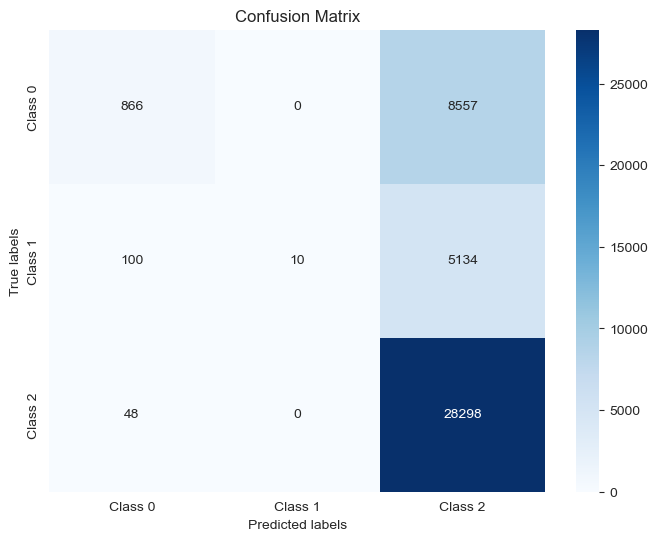

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


**use bigram to improve recall**

In [38]:
# Create a CountVectorizer with bigram tokenization
vectorizer = CountVectorizer(ngram_range=(1, 2))  # This will create both unigrams and bigrams
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)
X_val_counts = vectorizer.transform(X_val)

# Train the Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_counts, y_train)

# Evaluate the model on the test data
test_score = nb_clf.score(X_test_counts, y_test)
print(f"Test accuracy with bigrams: {test_score:.2f}")

# Evaluate the model on the validation data
val_score = nb_clf.score(X_val_counts, y_val)
print(f"Validation accuracy: {val_score:.2f}")

# Predict on the test set
y_pred = nb_clf.predict(X_test_counts)

Test accuracy with bigrams: 0.81
Validation accuracy: 0.82


In [39]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.61      0.71      9423
     neutral       0.98      0.26      0.41      5244
    positive       0.80      0.98      0.88     28346

    accuracy                           0.81     43013
   macro avg       0.87      0.62      0.67     43013
weighted avg       0.83      0.81      0.79     43013



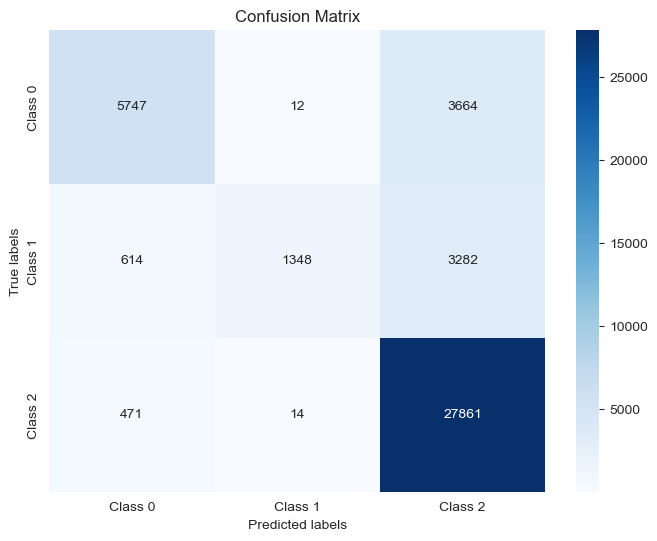

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Naive Bayes with feature selection

Test accuracy with bigrams and feature selection: 0.70
Validation accuracy with feature selection: 0.70


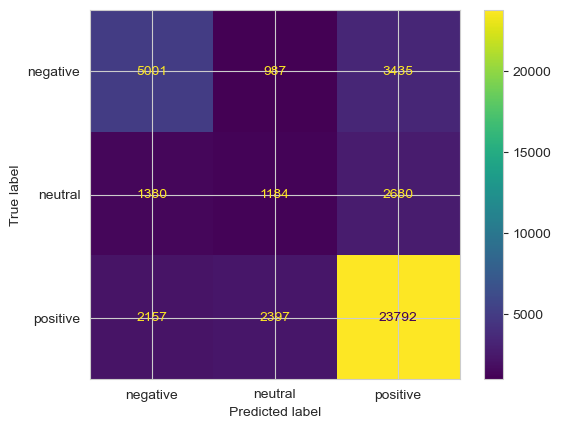

              precision    recall  f1-score   support

    negative       0.59      0.53      0.56      9423
     neutral       0.26      0.23      0.24      5244
    positive       0.80      0.84      0.82     28346

    accuracy                           0.70     43013
   macro avg       0.55      0.53      0.54     43013
weighted avg       0.68      0.70      0.69     43013



In [41]:
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a CountVectorizer with bigram tokenization
vectorizer = CountVectorizer(ngram_range=(1, 2))

X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)
X_val_counts = vectorizer.transform(X_val)

# Feature selection using Chi-square test
chi2_scores = chi2(X_train_counts, y_train)
top_features = sorted([(feature, score) for feature, score in zip(vectorizer.get_feature_names_out(), chi2_scores[0])], key=lambda x: x[1], reverse=True)[:1000]
top_feature_names = [feature for feature, score in top_features]

# Create a new vectorizer with selected features
vectorizer_selected = CountVectorizer(vocabulary=top_feature_names)
X_train_selected = vectorizer_selected.fit_transform(X_train)
X_test_selected = vectorizer_selected.transform(X_test)
X_val_selected = vectorizer_selected.transform(X_val)

# Train the Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_selected, y_train)

# Evaluate the model on the test data
test_score = nb_clf.score(X_test_selected, y_test)
print(f"Test accuracy with bigrams and feature selection: {test_score:.2f}")

# Evaluate the model on the validation data
val_score = nb_clf.score(X_val_selected, y_val)
print(f"Validation accuracy with feature selection: {val_score:.2f}")

# Predict on the test set
y_pred = nb_clf.predict(X_test_selected)

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=nb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_clf.classes_)
disp.plot()
plt.show()

# Classification report visualization
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=nb_clf.classes_))

# Decision tree

In [42]:
from sklearn.tree import DecisionTreeClassifier

# Create the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_val_dt = dt_model.predict(X_val_tfidf)

# Calculate accuracy on the validation set
accuracy_val_dt = accuracy_score(y_val, y_pred_val_dt)
print("Decision Tree Validation Accuracy:", accuracy_val_dt)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test_tfidf)

# Calculate accuracy on the test set
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Test Accuracy:", accuracy_dt)


Decision Tree Validation Accuracy: 0.8108398721301947
Decision Tree Test Accuracy: 0.8164740892288378


In [43]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.71      0.72      9423
     neutral       0.65      0.59      0.62      5244
    positive       0.87      0.89      0.88     28346

    accuracy                           0.82     43013
   macro avg       0.75      0.73      0.74     43013
weighted avg       0.81      0.82      0.81     43013



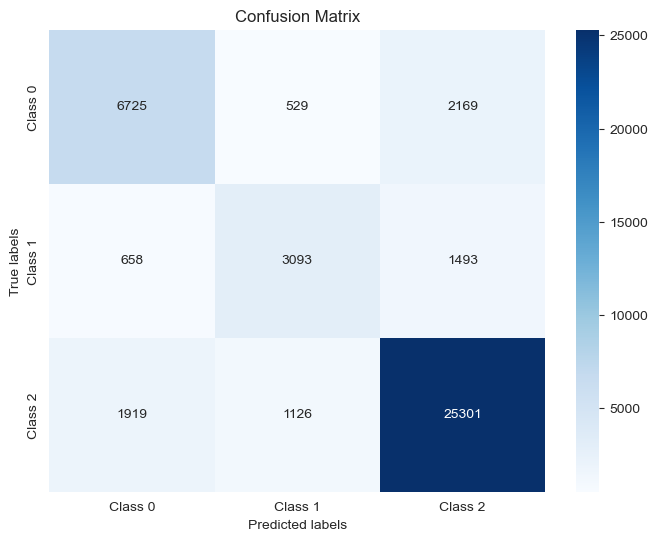

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**Use bigram**

In [45]:

# Initialize the TF-IDF vectorizer with the custom tokenizer
vectorizer = CountVectorizer(ngram_range=(1, 2))  # This will create both unigrams and bigrams

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the validation and test data using the fitted vectorizer
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Create the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_val_dt2 = dt_model.predict(X_val_tfidf)

# Predict on the test set
y_pred_dt2 = dt_model.predict(X_test_tfidf)

# Calculate accuracy on the validation set
accuracy_val_dt2 = accuracy_score(y_val, y_pred_val_dt2)
print("Decision Tree Validation Accuracy:", accuracy_val_dt2)

# Calculate accuracy on test set
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Test Accuracy:", accuracy_dt)


Decision Tree Validation Accuracy: 0.8258936355710549
Decision Tree Test Accuracy: 0.8164740892288378


In [46]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))


Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.71      0.72      9423
     neutral       0.65      0.59      0.62      5244
    positive       0.87      0.89      0.88     28346

    accuracy                           0.82     43013
   macro avg       0.75      0.73      0.74     43013
weighted avg       0.81      0.82      0.81     43013



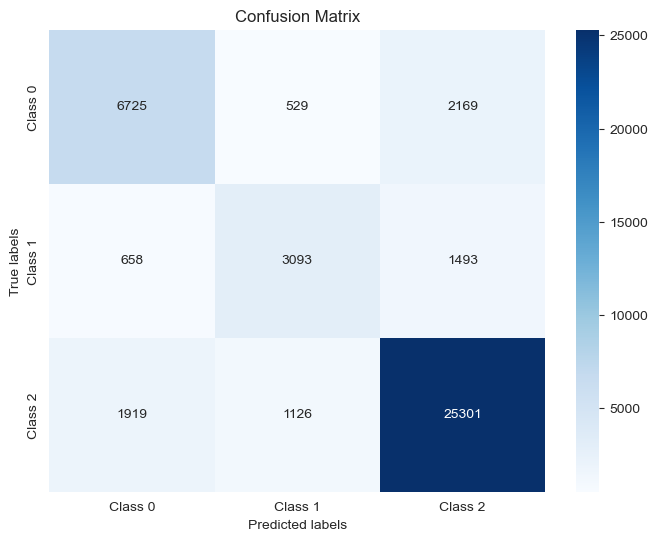

In [47]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# LSTM

In [49]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)

# Pad the sequences to have the same length
max_length = max([len(seq) for seq in X])
X = pad_sequences(X, maxlen=max_length)

# Convert the target variable to numerical labels
unique_labels = y.unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_encoded = y.map(label_mapping)

# Apply SMOTE to oversample the minority class(es)
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X, y_encoded)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the LSTM model architecture
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128),
    Dense(len(unique_labels), activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate on the test set
y_pred_lstm = model.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_classes_lstm)
print("LSTM Accuracy:", accuracy_lstm)

# Calculate precision, recall, and F1-score
precision_lstm = precision_score(y_test, y_pred_classes_lstm, average='weighted')
recall_lstm = recall_score(y_test, y_pred_classes_lstm, average='weighted')
f1_lstm = f1_score(y_test, y_pred_classes_lstm, average='weighted')
print("LSTM Precision:", precision_lstm)
print("LSTM Recall:", recall_lstm)
print("LSTM F1-score:", f1_lstm)

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
10673/10673 ━━━━━━━━━━━━━━━━━━━━ 5735s 537ms/step - accuracy: 0.5669 - loss: 0.8585 - val_accuracy: 0.6522 - val_loss: 0.6921
Epoch 2/5
10673/10673 ━━━━━━━━━━━━━━━━━━━━ 5994s 562ms/step - accuracy: 0.6896 - loss: 0.6226 - val_accuracy: 0.6888 - val_loss: 0.6264
Epoch 3/5
10673/10673 ━━━━━━━━━━━━━━━━━━━━ 5919s 555ms/step - accuracy: 0.7526 - loss: 0.5038 - val_accuracy: 0.7096 - val_loss: 0.5936
Epoch 4/5
10673/10673 ━━━━━━━━━━━━━━━━━━━━ 5843s 547ms/step - accuracy: 0.8010 - loss: 0.4099 - val_accuracy: 0.7236 - val_loss: 0.6154
Epoch 5/5
10673/10673 ━━━━━━━━━━━━━━━━━━━━ 5759s 540ms/step - accuracy: 0.8432 - loss: 0.3326 - val_accuracy: 0.7290 - val_loss: 0.6354
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 524s 196ms/step
LSTM Accuracy: 0.7289656141665886


NameError: name 'precision_score' is not defined

2669/2669 ━━━━━━━━━━━━━━━━━━━━ 1881s 705ms/step
LSTM Accuracy: 0.7289656141665886
LSTM Precision: 0.731999925681485
LSTM Recall: 0.7289656141665886
LSTM F1-score: 0.7289249357369898


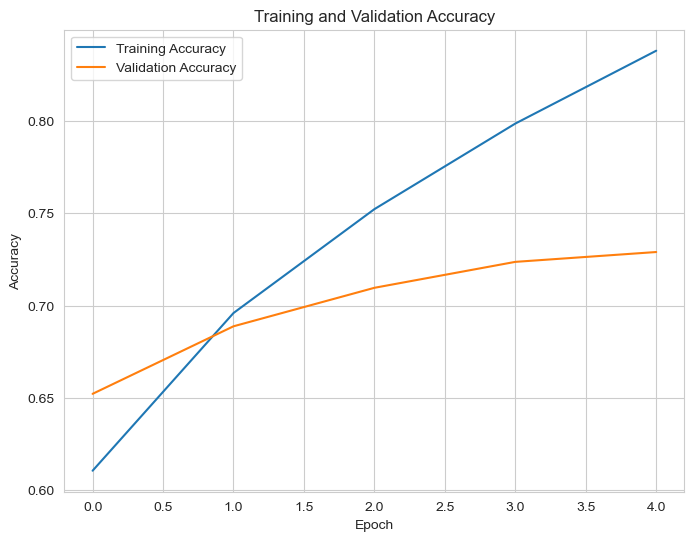

In [52]:

# Evaluate on the test set
y_pred_lstm = model.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_classes_lstm)
print("LSTM Accuracy:", accuracy_lstm)

# Calculate precision, recall, and F1-score
precision_lstm = precision_score(y_test, y_pred_classes_lstm, average='weighted')
recall_lstm = recall_score(y_test, y_pred_classes_lstm, average='weighted')
f1_lstm = f1_score(y_test, y_pred_classes_lstm, average='weighted')
print("LSTM Precision:", precision_lstm)
print("LSTM Recall:", recall_lstm)
print("LSTM F1-score:", f1_lstm)

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# LSTM hypertuning

**increased LSTM units to 256**

**increased embed layer 200**

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)

# Pad the sequences to have the same length
max_length = max([len(seq) for seq in X])
X = pad_sequences(X, maxlen=max_length)

# Convert the target variable to numerical labels
unique_labels = y.unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_encoded = y.map(label_mapping)

# Apply SMOTE to oversample the minority class(es)
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X, y_encoded)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the LSTM model architecture
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(256),
    Dense(len(unique_labels), activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate on the test set
y_pred_lstm = model.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_classes_lstm)
print("LSTM Accuracy:", accuracy_lstm)

# Calculate precision, recall, and F1-score
precision_lstm = precision_score(y_test, y_pred_classes_lstm, average='weighted')
recall_lstm = recall_score(y_test, y_pred_classes_lstm, average='weighted')
f1_lstm = f1_score(y_test, y_pred_classes_lstm, average='weighted')
print("LSTM Precision:", precision_lstm)
print("LSTM Recall:", recall_lstm)
print("LSTM F1-score:", f1_lstm)

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
10673/10673 ━━━━━━━━━━━━━━━━━━━━ 15899s 1s/step - accuracy: 0.5652 - loss: 0.8575 - val_accuracy: 0.6588 - val_loss: 0.6799
Epoch 2/5
10673/10673 ━━━━━━━━━━━━━━━━━━━━ 21208s 2s/step - accuracy: 0.7002 - loss: 0.6027 - val_accuracy: 0.6944 - val_loss: 0.6065
Epoch 3/5
 2080/10673 ━━━━━━━━━━━━━━━━━━━━ 3:58:12 2s/step - accuracy: 0.7686 - loss: 0.4703

# CNN

In [70]:
x=revw_strings
y=df['sentiment']

In [72]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

#Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)

# Pad the sequences to have the same length
max_length = max([len(seq) for seq in X])
X = pad_sequences(X, maxlen=max_length)

# Convert the target variable to numerical labels
unique_labels = np.unique(y)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_encoded = np.array([label_mapping[label] for label in y])

# Apply SMOTE to oversample the minority class(es)
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X, y_encoded)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# Define the vocabulary size and embedding dimension
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=len(unique_labels), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 1435s 168ms/step - accuracy: 0.5456 - loss: 0.8776 - val_accuracy: 0.6504 - val_loss: 0.7062
Epoch 2/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 1410s 165ms/step - accuracy: 0.6892 - loss: 0.6217 - val_accuracy: 0.6729 - val_loss: 0.6735
Epoch 3/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 1476s 173ms/step - accuracy: 0.7594 - loss: 0.4818 - val_accuracy: 0.7029 - val_loss: 0.6388
Epoch 4/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 1566s 183ms/step - accuracy: 0.8220 - loss: 0.3673 - val_accuracy: 0.7110 - val_loss: 0.7152
Epoch 5/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 1438s 168ms/step - accuracy: 0.8761 - loss: 0.2734 - val_accuracy: 0.7123 - val_loss: 0.8235
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 64s 24ms/step - accuracy: 0.7124 - loss: 0.8201
Test Loss: 0.8193, Test Accuracy: 0.7122


In [74]:
# Evaluate the models
y_pred_classes_cnn = np.argmax(model.predict(X_test), axis=1)

# Calculate accuracy, precision, recall, and F1-score for CNN
accuracy_cnn = accuracy_score(y_test, y_pred_classes_cnn)
precision_cnn = precision_score(y_test, y_pred_classes_cnn, average='weighted')
recall_cnn = recall_score(y_test, y_pred_classes_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_classes_cnn, average='weighted')

print("CNN Accuracy:", accuracy_cnn)
print("CNN Precision:", precision_cnn)
print("CNN Recall:", recall_cnn)
print("CNN F1-score:", f1_cnn)


2669/2669 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step
CNN Accuracy: 0.7121708985289984
CNN Precision: 0.7118359579364876
CNN Recall: 0.7121708985289984
CNN F1-score: 0.7119693782933582


# CNN 

**embedded layer 200, filter 256, dense unit 128**

In [78]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

#Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)

# Pad the sequences to have the same length
max_length = max([len(seq) for seq in X])
X = pad_sequences(X, maxlen=max_length)

# Convert the target variable to numerical labels
unique_labels = np.unique(y)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_encoded = np.array([label_mapping[label] for label in y])

# Apply SMOTE to oversample the minority class(es)
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X, y_encoded)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# Define the vocabulary size and embedding dimension
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200 #increased dim to 200

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))  #increased filter 256
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=len(unique_labels), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history= model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 3848s 450ms/step - accuracy: 0.5551 - loss: 0.8616 - val_accuracy: 0.6434 - val_loss: 0.7181
Epoch 2/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 3771s 442ms/step - accuracy: 0.6889 - loss: 0.6120 - val_accuracy: 0.6840 - val_loss: 0.6465
Epoch 3/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 19315s 2s/step - accuracy: 0.7693 - loss: 0.4572 - val_accuracy: 0.7087 - val_loss: 0.6541
Epoch 4/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 4816s 564ms/step - accuracy: 0.8342 - loss: 0.3387 - val_accuracy: 0.7136 - val_loss: 0.7670
Epoch 5/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 3985s 467ms/step - accuracy: 0.8914 - loss: 0.2409 - val_accuracy: 0.7117 - val_loss: 0.8688
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 212s 79ms/step - accuracy: 0.7144 - loss: 0.8558
Test Loss: 0.8439, Test Accuracy: 0.7178


2669/2669 ━━━━━━━━━━━━━━━━━━━━ 188s 70ms/step
CNN Accuracy: 0.717827696055467
CNN Precision: 0.7185520068316308
CNN Recall: 0.717827696055467
CNN F1-score: 0.7179741178528364


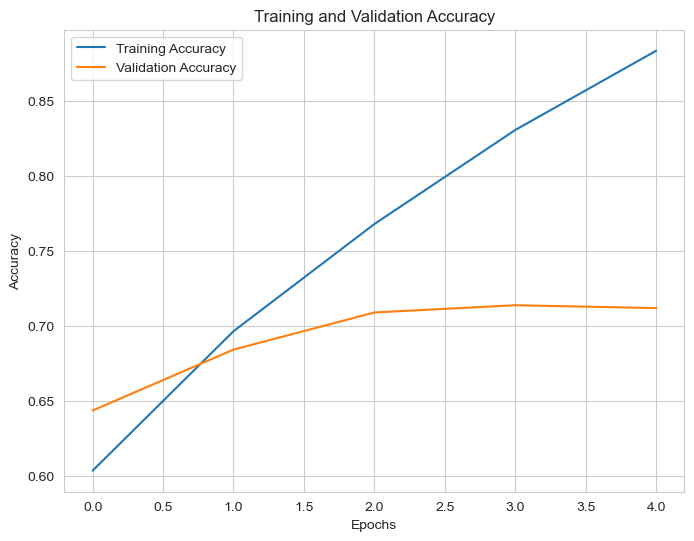

In [80]:
# Evaluate the models
y_pred_classes_cnn = np.argmax(model.predict(X_test), axis=1)

# Calculate accuracy, precision, recall, and F1-score for CNN
accuracy_cnn = accuracy_score(y_test, y_pred_classes_cnn)
precision_cnn = precision_score(y_test, y_pred_classes_cnn, average='weighted')
recall_cnn = recall_score(y_test, y_pred_classes_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_classes_cnn, average='weighted')

print("CNN Accuracy:", accuracy_cnn)
print("CNN Precision:", precision_cnn)
print("CNN Recall:", recall_cnn)
print("CNN F1-score:", f1_cnn)

# Visualize training accuracy and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# CNN hypertuning 
**10 epochs, 200 embeded dim, x2 128 filter, 2 kernel size, 256 dense units, 32 batch size**

In [81]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)

# Pad the sequences to have the same length
max_length = max([len(seq) for seq in X])
X = pad_sequences(X, maxlen=max_length)

# Convert the target variable to numerical labels
unique_labels = np.unique(y)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_encoded = np.array([label_mapping[label] for label in y])

# Apply SMOTE to oversample the minority class(es)
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X, y_encoded)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the vocabulary size and embedding dimension
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200  # Embedding dimension remains 200

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))  # Reduced kernel size to 2
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))  # Reduced dense units to 128
model.add(Dense(units=len(unique_labels), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)  # Reduced batch size to 32

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 3201s 372ms/step - accuracy: 0.5311 - loss: 0.9011 - val_accuracy: 0.6346 - val_loss: 0.7299
Epoch 2/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 2306s 270ms/step - accuracy: 0.6709 - loss: 0.6523 - val_accuracy: 0.6615 - val_loss: 0.6805
Epoch 3/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 2269s 266ms/step - accuracy: 0.7388 - loss: 0.5217 - val_accuracy: 0.6862 - val_loss: 0.6702
Epoch 4/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 2270s 266ms/step - accuracy: 0.7990 - loss: 0.4128 - val_accuracy: 0.6850 - val_loss: 0.7344
Epoch 5/5
8539/8539 ━━━━━━━━━━━━━━━━━━━━ 2371s 278ms/step - accuracy: 0.8547 - loss: 0.3151 - val_accuracy: 0.6980 - val_loss: 0.8169
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 98s 37ms/step - accuracy: 0.6971 - loss: 0.8320
Test Loss: 0.8334, Test Accuracy: 0.6974


2669/2669 ━━━━━━━━━━━━━━━━━━━━ 98s 37ms/step
CNN Accuracy: 0.6974140354164715
CNN Precision: 0.7068605917549504
CNN Recall: 0.6974140354164715
CNN F1-score: 0.6991459425813119


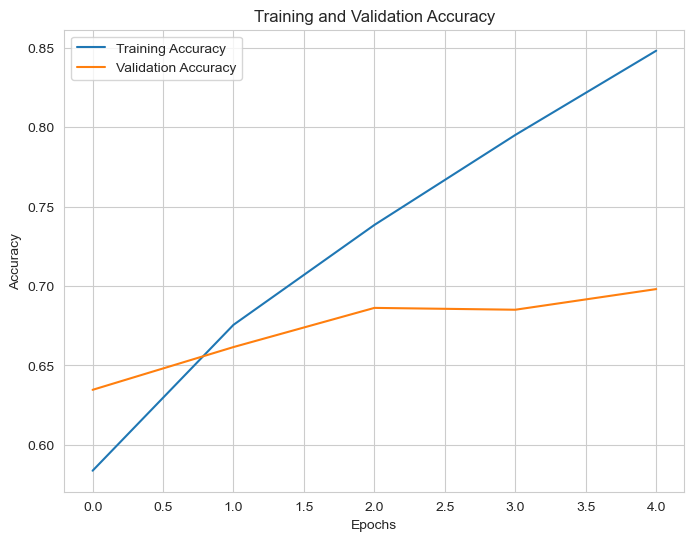

In [82]:
# Evaluate the models
y_pred_classes_cnn = np.argmax(model.predict(X_test), axis=1)

# Calculate accuracy, precision, recall, and F1-score for CNN
accuracy_cnn = accuracy_score(y_test, y_pred_classes_cnn)
precision_cnn = precision_score(y_test, y_pred_classes_cnn, average='weighted')
recall_cnn = recall_score(y_test, y_pred_classes_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_classes_cnn, average='weighted')

print("CNN Accuracy:", accuracy_cnn)
print("CNN Precision:", precision_cnn)
print("CNN Recall:", recall_cnn)
print("CNN F1-score:", f1_cnn)

# Visualize training accuracy and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()